# Métodos de clustering avanzados

Autor: José María Manzano Ortega

#### Contenidos:
* [Clustering basado en densidad DBSCAN](#Clustering-basado-en-densidad-DBSCAN)
* [Clústering Jerárquico](#Clústering-jerárquico)   

## Preliminares

In [1]:
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.datasets import load_iris

In [2]:
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df_norm = (df-df.min())/ (df.max()-df.min())

In [3]:
def mostrar(X, c=None, centroids=None,i=0,j=0):

    # Creamos los mapas de colores a utilizar
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#FFFF00', '#0000FF'])

    # Creamos la figura
    plt.figure(figsize=(10,8))

    # Pintamos los puntos
    plt.scatter(X.iloc[:, i], X.iloc[:, j], c=c, cmap=cmap_bold, s=60)

    # Pintamos los centroides si los hay
    # ligero cambios con respecto a la función del notebook anterior
    if centroids is not None:
        plt.scatter(centroids[:,i], centroids[:,j], marker='*', c=range(centroids.shape[0]), s=500)

    # Mostramos la figura
    plt.show()

### Clustering basado en densidad: DBSCAN
Otro de los tipos de algoritmos de *clustering* que podemos utilizar son los basados en densidad. De este tipo, el más conocido es el algoritmo DBSCAN (Density Based Spatial Clustering of Application with Noise). Este algoritmo se puede aplicar cuando los *clusters* tienen formas arbitrarias, ya que no trata de englobarlos dentro de un modelo predifinido. Por contra, selecciona los grupos como aquellas regiones con suficiente densidad de datos. Por ello, es capaz de identificar aquellos datos que no se encuentran en zonas densas, por lo que podemos decir que es capaz de detectar outliers. Como ventaja añadida frente a los algoritmos de particiones, no necesita saber de antemano el número de *clusters* que existen en el dataset.

Como es un algoritmo basado en densidades, necesitamos ajustar dos parámetros que son cruciales para que el algoritmo pueda ejecutarse apropiadamente:
* **radio** a considerar para localizar puntos cercanos
* número **mínimo** de puntos que se consideran suficientes para ser región densa
Mediante estos dos parámetros, el algoritmo define qué se considera por región densa de datos: cuando en un radio alrededor de un dato hay al menos el número mínimo de datos.

Una vez que tenemos definidos estos parámetros, podemos clasificar cada uno de los datos del dataset como una de estas tres categorías:
* **núcleo**: es un dato que en el radio fijado está rodeado por suficientes puntos
* **borde**: es un dato que no tiene suficientes vecinos en el radio marcado, pero alguno de estos vecinos es un núcleo
* **outlier**: todos los datos que no sean núcleo ni borde

Cuando todos los datos han sido clasificados, el algoritmo ya puede crear los *clusters*.
1. En primer lugar, asigna todos los datos núcleo que sean vecinos al mismo *cluster*.
2. Posteriormente asigna cada dato borde al *cluster* al que pertenezca su dato núcleo más cercano.
3. Los datos outliers se mantienen como tal, ya que no pertenecen a ningún *cluster*.

A la hora de ejecutarlo en [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), el parámetro eps indica la distancia máxima para ser considerado vecino, y el parámetro min_samples indica el número mínimo de vecinos para ser considerado dato núcleo.

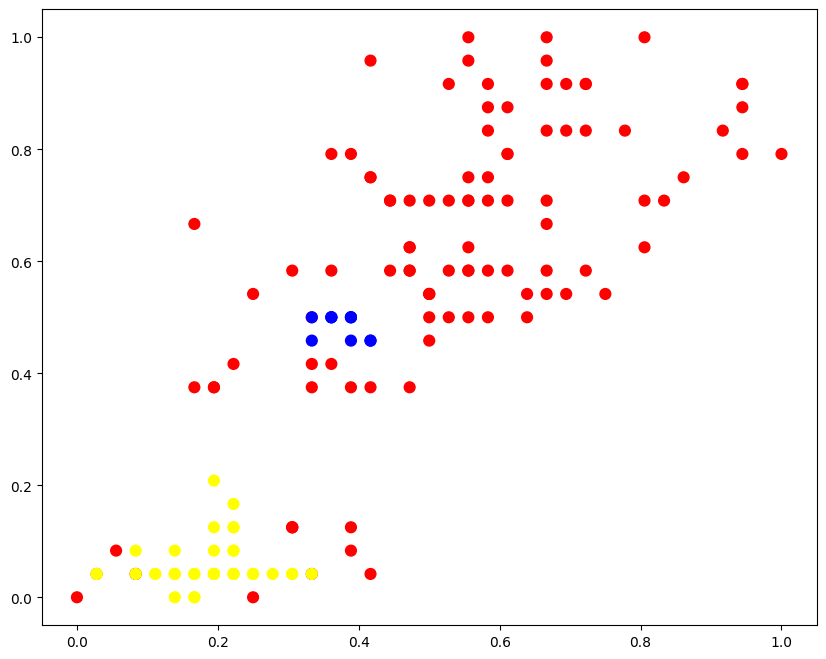

In [4]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.1, min_samples=7).fit(df_norm)
etiquetas=clustering.labels_
mostrar(df_norm, etiquetas, i=0,j=3)

### Clústering jerárquico <a class="anchor" id="32.7"></a>
El objetivo del *clustering* jerárquico no es solo agrupar los datos en conjuntos disjuntos, sino mostrar el proceso de estos agrupamientos. Por ello, una de las formas más habituales de mostrar los resultados de un proceso de *clustering* jerárquico es mediante un dendograma. Este tipo de visualización es un árbol en el que en la parte inferior aparecen todos los datos que disponemos. Dependiendo de las distancias entre ellos, el árbol muestra cómo se van a grupando los datos. Cada vez que dos datos se agrupan, en el dendograma se muestra esta unión con una altura determinada, que indica la distancia existente entre esos dos datos.

![dendograma.PNG](attachment:dendograma.PNG)

Principalmente, existen dos estrategias para realizar el *clustering* jerárquico:
* Aglomerativo o bottom-up: cada dato comienza estando en su propio *cluster* de manera individual. En cada paso, se seleccionan los dos *clusters* más cercanos para fusionarse en un único *cluster*. El proceso termina cuando todos los datos están en un mismo *cluster*.
* Divisivo o bottom-down: todos los datos comienzan en un único cluster. En cada paso, se elige el cluster con datos más dispares entre sí, y se divide en dos clusters. El proceso termina cuando cada dato pertenece a un *cluster* individual.

Si representamos los resultados obtenidos en un dendograma, podemos ver claramente cómo se van formando los clusters. Dependiendo de la altura a la que cortemos el dendograma (en horizontal) podemos agrupar todos los datos en un número variable de *clusters*.

En scikit está implementada la versión aglomerativa del *clustering* jerárquico.

In [5]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

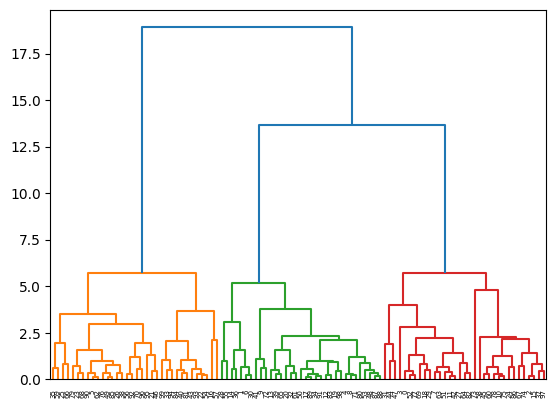

In [6]:
from sklearn.cluster import AgglomerativeClustering
import sklearn.datasets

datos_creados=sklearn.datasets.make_blobs(n_samples=100, random_state=333)
datos=np.array(datos_creados[0])
clases=np.array(datos_creados[1])
clustering = AgglomerativeClustering(metric='euclidean',linkage='complete',distance_threshold=0,n_clusters= None).fit(X=datos)
plot_dendrogram(clustering, color_threshold=10)

Cuando los clusters contienen un único dato, medir la distancia entre *clusters* es muy sencillo, ya que solo necesitamos medir la distancia entre los dos datos. Sin embargo, cuando tenemos varios datos en cada *cluster* hay varias formas de medir la distancia entre dos *clusters* A y B:
* **single linkage**: distancia mínima entre un dato que pertenece al *cluster* A y otro que pertenece al *cluster* B
* **complete linkage**: máxima distancia entre un dato que pertenece al *cluster* A y otro que pertenece al *cluster* B
* **average linkage**: distancia media entre las distancias de todos los pares con un dato en el *cluster* A y otro dato en el *cluster* B

Vamos a crear algunos datos artificiales con sklearn:

In [7]:
datos_creados=sklearn.datasets.make_blobs(n_samples=50, centers=4, random_state=13)
datos=np.array(datos_creados[0])
clases=np.array(datos_creados[1])

In [8]:
datos.shape

(50, 2)

<Axes: >

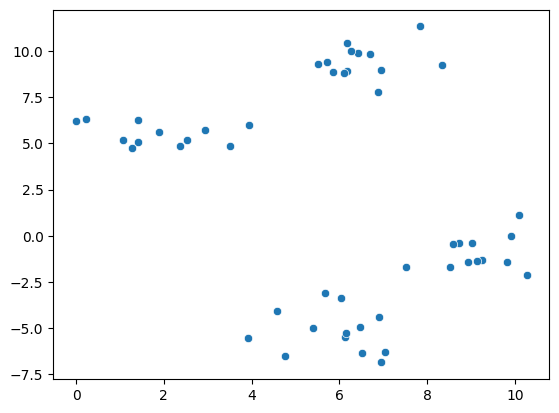

In [9]:
plt.figure()
sns.scatterplot(x=datos[:,0], y=datos[:,1])

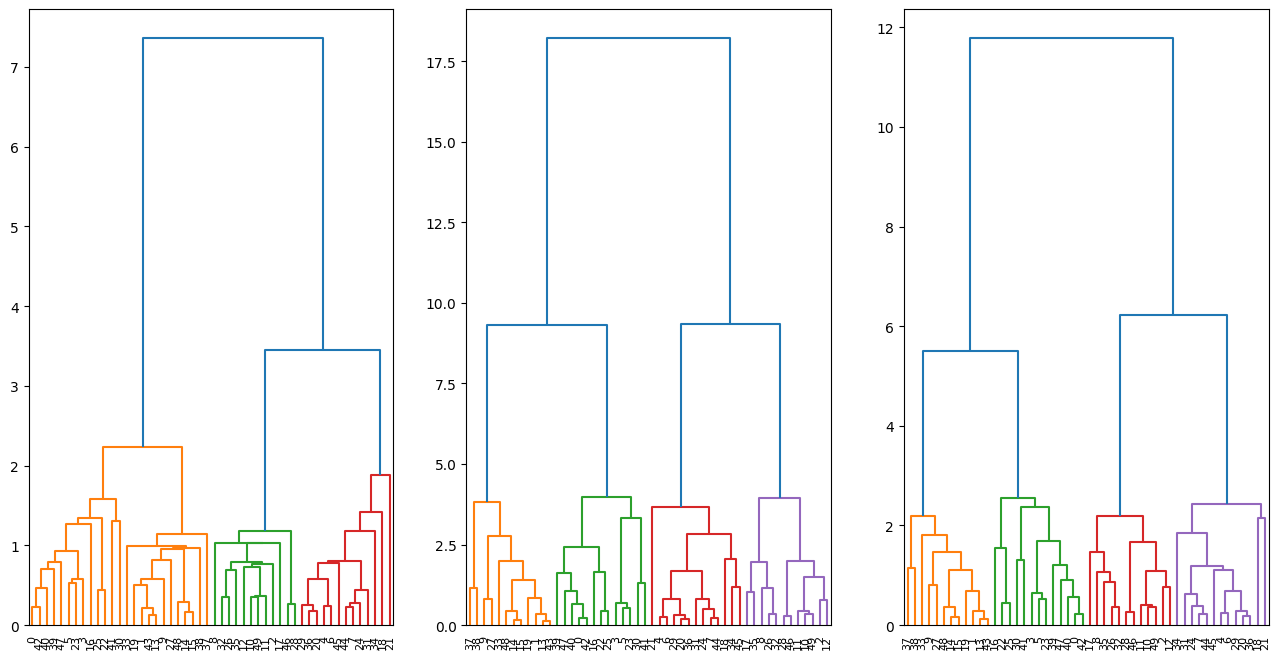

In [10]:
figura, axes = plt.subplots(1,3,figsize=(16, 8))
clustering1 = AgglomerativeClustering(metric='euclidean',linkage='single',distance_threshold=0,n_clusters= None).fit(X=datos)
plot_dendrogram(clustering1, color_threshold=3, ax=axes[0])
clustering2 = AgglomerativeClustering(metric='euclidean',linkage='complete',distance_threshold=0,n_clusters= None).fit(X=datos)
plot_dendrogram(clustering2, color_threshold=8, ax=axes[1])
clustering3 = AgglomerativeClustering(metric='euclidean',linkage='average',distance_threshold=0,n_clusters= None).fit(X=datos)
plot_dendrogram(clustering3, color_threshold=3, ax=axes[2])

Creemos otro dataset artificial con forma de lunas:

<Axes: >

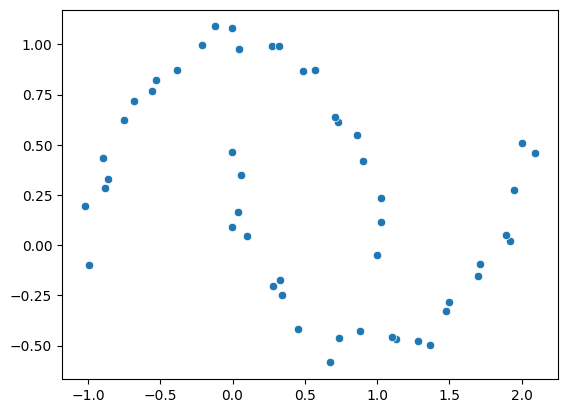

In [11]:
from sklearn.datasets import make_moons

datos, clases = make_moons(n_samples=50, noise=0.05, random_state=123)
plt.figure()
sns.scatterplot(x=datos[:,0], y=datos[:,1])

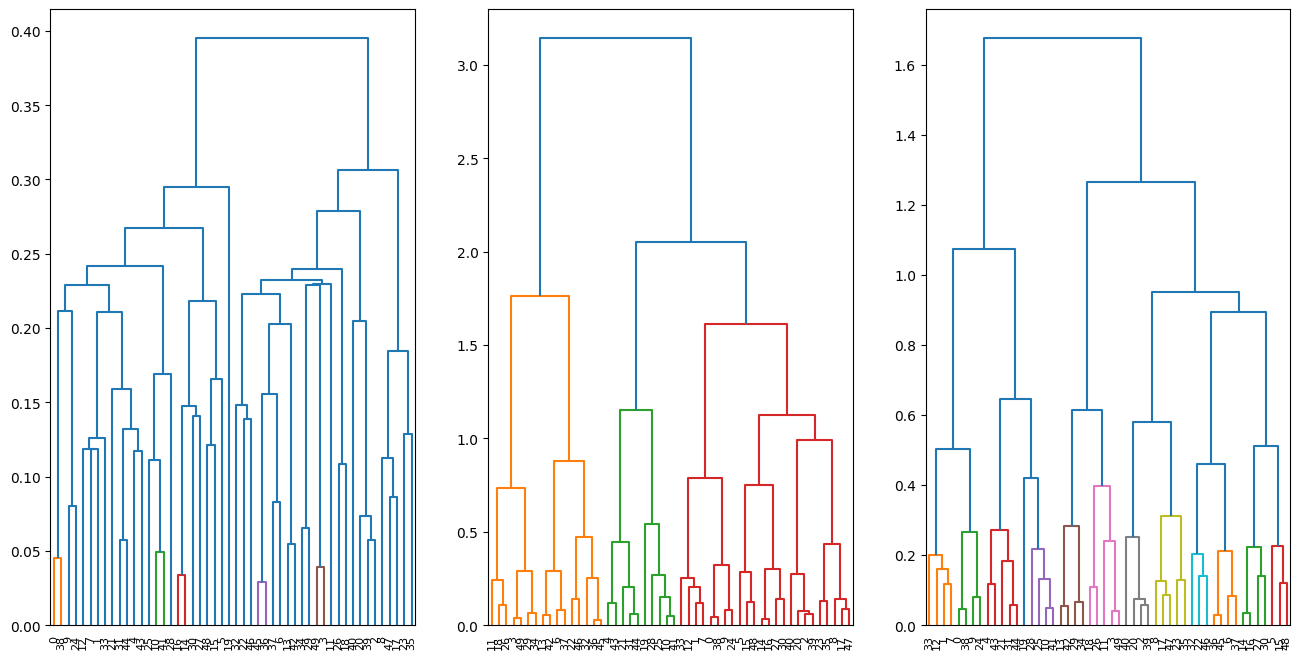

In [12]:
figura, axes = plt.subplots(1,3,figsize=(16, 8))
clustering1 = AgglomerativeClustering(metric='euclidean',linkage='single',distance_threshold=0,n_clusters= None).fit(X=datos)
plot_dendrogram(clustering1, color_threshold=0.05, ax=axes[0])
clustering2 = AgglomerativeClustering(metric='euclidean',linkage='complete',distance_threshold=0,n_clusters= None).fit(X=datos)
plot_dendrogram(clustering2, color_threshold=2, ax=axes[1])
clustering3 = AgglomerativeClustering(metric='euclidean',linkage='average',distance_threshold=0,n_clusters= None).fit(X=datos)
plot_dendrogram(clustering3, color_threshold=0.4, ax=axes[2])